In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LinearRegression 
import tensorflow as tf
import keras
import copy

2024-10-23 13:23:19.838523: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Dataset:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand]. Irvine, CA: University of California, School of Information and Computer Science.

Source: Data Source :http://data.seoul.go.kr/
SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

Date : year-month-day

Rented Bike count - Count of bikes rented at each hour

Hour - Hour of he day

Temperature-Temperature in Celsius

Humidity - %

Windspeed - m/s

Visibility - 10m

Dew point temperature - Celsius 

Solar radiation - MJ/m2

Rainfall - mm

Snowfall - cm

Seasons - Winter, Spring, Summer, Autumn

Holiday - Holiday/No holiday

Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

In [2]:
# Define the columns for the dataset, renaming them to more meaningful labels
dataset_cols = ["bike_count", "temp", "humidity", "wind", "visibility", "dew_pt_temp", 
                "radiation", "rain", "snow", "functional"]

# Read the CSV file containing the Seoul bike data, using specific encoding
# Drop columns that are not needed for this analysis: "Date", "Holiday", "Seasons", and "Hour"
df = pd.read_csv("./file/SeoulBikeData.csv", encoding='ISO-8859-1').drop(["Date", "Holiday", "Seasons", "Hour"], axis=1)

# Rename the columns in the dataframe to the ones defined in dataset_cols
df.columns = dataset_cols

# Display the first few rows of the dataframe to check the data
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [3]:
# Print the unique value in the column
df["functional"].unique()

array(['Yes', 'No'], dtype=object)

In [4]:
# Convert the "functional" column to a binary format
# If the value is "Yes", it becomes 1 (True), otherwise 0 (False)
df["functional"] = (df["functional"] == "Yes").astype(int)

# Display the first few rows of the dataframe to check the changes
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1


In [5]:
df = df.drop(["wind", "visibility", "functional"], axis=1)

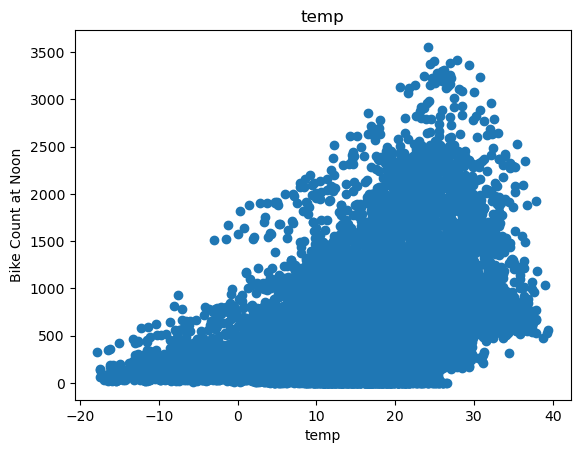

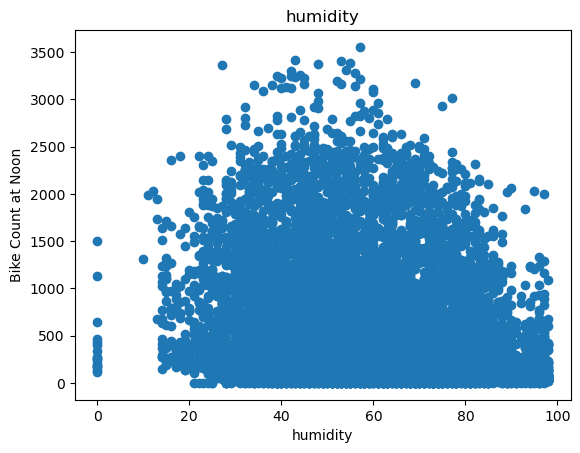

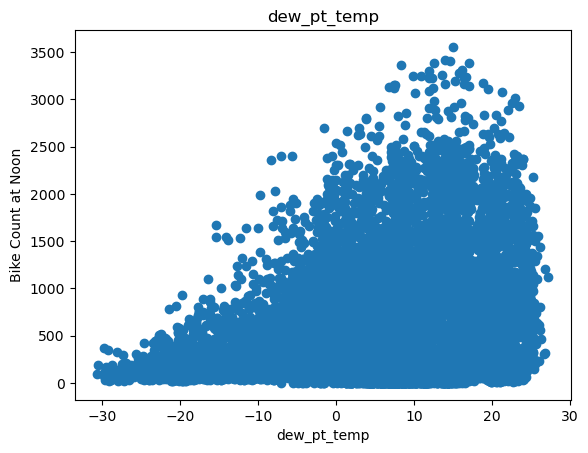

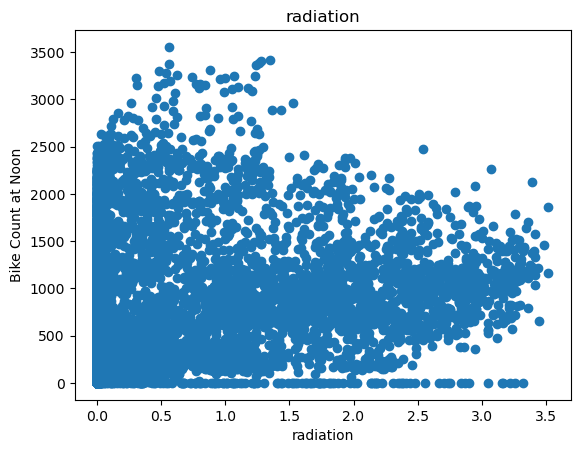

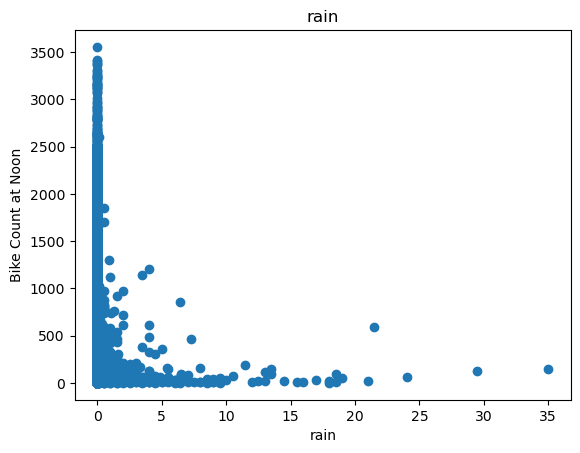

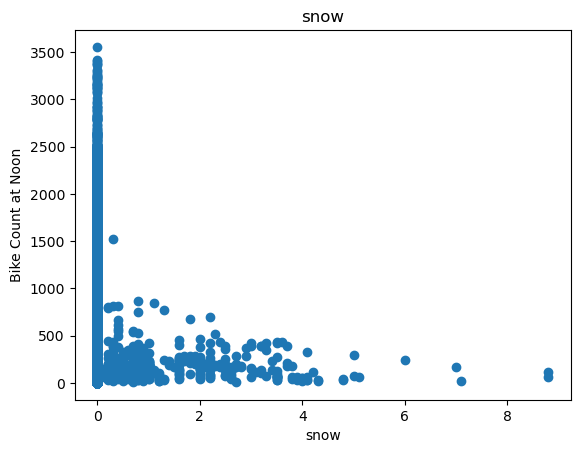

In [6]:
# Iterate over all columns in the dataframe, starting from the second column (excluding 'bike_count')
for label in df.columns[1:]:
  
  # Create a scatter plot for each column against the 'bike_count' column
  plt.scatter(df[label], df["bike_count"])
  
  # Set the title of the plot to the column name (label)
  plt.title(label)
  
  # Label the y-axis as "Bike Count at Noon"
  plt.ylabel("Bike Count at Noon")
  
  # Label the x-axis with the current column name (label) for clarity
  plt.xlabel(label)
  
  # Display the plot
  plt.show()


# Train/Valid/Test Dataset

In [7]:
## Shuffle the DataFrame using sample() method, frac=1 keeps all rows, and random_state ensures reproducibility
df_shuffled = df.sample(frac=1, random_state=42)

# Split the shuffled DataFrame into 3 parts:
# 60% for training, 20% for validation, and 20% for testing
train, valid, test = np.split(df_shuffled,[
                               int(0.6 * len(df)),  # First 60% for training
                               int(0.8 * len(df))
]) # Next 20% for validation, rest for testing

/nix/store/gdckiap2g28wl5b5i8rhm98ijxkln6v7-python3.11-numpy-1.26.4/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [8]:
def get_xy(dataframe, y_label, x_labels=None):
    # Create a deep copy of the DataFrame to avoid altering the original data
    dataframe = copy.deepcopy(dataframe)

    # If no specific x_labels (features) are provided, select all columns except the target (y_label)
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values  # All columns except y_label
    else:
        # If only one x_label (feature) is provided, reshape it to 2D for compatibility with models
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        # If multiple x_labels (features) are provided, just select those columns
        else:
            X = dataframe[x_labels].values

    # Extract the target variable (Y) and reshape it to a column vector
    Y = dataframe[y_label].values.reshape(-1, 1)
    
    # Combine X (features) and Y (target) horizontally into a single dataset
    data = np.hstack((X, Y))

    # Return the combined dataset, feature matrix X, and target vector Y
    return data, X, Y

# Simple Linear Regression

In [9]:
# Get feature (temperature) and target (bike_count) for the training set
_, x_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])

# Get feature (temperature) and target (bike_count) for the validation set
_, x_valid_temp, y_valid_temp = get_xy(valid, "bike_count", x_labels=["temp"])

# Get feature (temperature) and target (bike_count) for the test set
_, x_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [10]:
print(x_train_temp)

[[27.2]
 [32.6]
 [34. ]
 ...
 [12.4]
 [19.1]
 [-4.2]]


In [11]:
temp_reg = LinearRegression()  # Create a Linear Regression model object
temp_reg.fit(x_train_temp, y_train_temp)  # Train the model using the training data (temp as feature, bike_count as target)

LinearRegression()

In [12]:
# Print the model's coefficients (slope) and intercept It's the point where the line crosses the y-axis.
print(temp_reg.coef_, temp_reg.intercept_)

[[29.13796554]] [332.19820887]


By running this line of code, you'll get a numerical output (R² score) indicating how well the linear regression model predicts bike count based on temperature in the test dataset.
A value close to 1 suggests that the model is effective in capturing the relationship between temperature and bike count.

In [13]:
# Evaluate the model on the test dataset
temp_reg.score(x_test_temp, y_test_temp) 

0.27124859077728913

In [14]:
def scatter_plot(x_train, y_train, model):
    # Scatter plot of training data (temperature vs. bike count)
    plt.scatter(x_train, y_train, label="Data", color="blue")  # Plot training data points

    # Create a range of temperature values for plotting the regression line
    x = np.linspace(-20, 40, 100)  # Generate 100 temperature values from -20 to 40
    
    # Predict the bike count for each temperature in the range using the trained regression model
    y = model.predict(np.array(x).reshape(-1, 1))  # Reshape x for prediction
    
    # Plot the regression line based on predictions
    plt.plot(x, y, label="Fit", color="red", linewidth=3)  # Plot the fitted line
    
    # Add legend (differentiate data points from the fit) and labels
    plt.legend()
    plt.title("Bikes vs Temp")
    plt.ylabel("Number of bikes") 
    plt.xlabel("Temp")
    plt.show()  

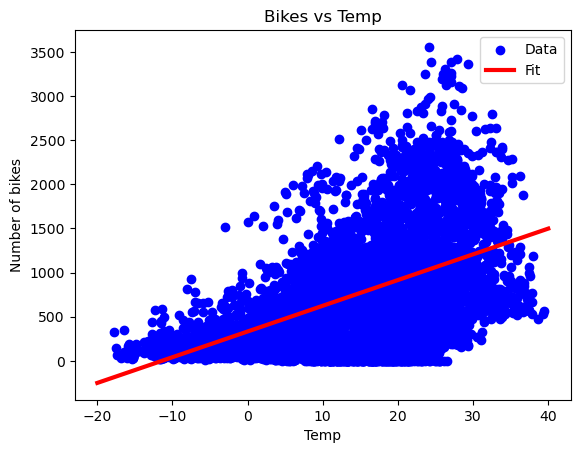

In [15]:
# Scatter plot of training data (temperature vs. bike count)
scatter_plot(x_train_temp, y_train_temp, temp_reg)

# Multiple Linear Regression

In [16]:
# Get all features (independent variables) except for the target variable 'bike_count' for the training set.
# The 'x_labels' are set to all columns except the first one (which is 'bike_count'), 
# so the model will use all other columns as features (input variables).
_, x_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])

# Get the features and target for the validation set in the same way as for the training set.
_, x_valid_all, y_valid_all = get_xy(valid, "bike_count", x_labels=df.columns[1:])

# Get the features and target for the test set.
_, x_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [17]:
# Initialize a Linear Regression model.
all_reg = LinearRegression()

# Train the model using the training data (all features except 'bike_count' as input, and 'bike_count' as the target).
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [18]:
# Evaluate the model's performance on the test set by calculating the R^2 score.
# This score measures how well the model's predictions match the actual data.
# A score of 1 means perfect prediction, while a score of 0 means the model is no better than random guessing.
all_reg.score(x_test_all, y_test_all)

0.38429992933406243

# Regression Nurel Net with One Single Node

In [19]:
def plot_loss(history):
    # Plot accuracy and validation accuracy over epochs 
    plt.plot(history.history['loss'], label='loss')  # Training loss
    plt.plot(history.history['val_loss'], label='val_loss')  # Validation loss
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.grid(True)  # Display a grid for easier visualization
    plt.legend()  # Add a legend to differentiate between accuracy and val_loss
    # Show the plots
    plt.show()

In [20]:
# Normalization layer for the input data (temperature).
# It expects input data with shape (1,), meaning one feature (temperature) per sample.
temp_normalizer = keras.layers.Normalization(input_shape=(1,), axis=None)

# Adapt the normalizer to the training data (i.e., calculate mean and variance from the training data).
temp_normalizer.adapt(x_train_temp)

/nix/store/94gnxgnjmb9qf7al231kdj46fjb6ajc8-python3.11-keras-3.6.0/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Create a simple regression model using a Sequential Keras model.
# The model has two layers:
# - First, the normalization layer to normalize the input data.
# - Second, a dense layer with 1 output node, as this is a regression problem (predicting 'bike_count').
temp_rnn_model = keras.Sequential([
    temp_normalizer,         # Normalizes the input temperature data
    keras.layers.Dense(1)    # Dense layer with 1 node for predicting 'bike_count'
])

# Compile the model specifying the optimizer (Adam) and the loss function (Mean Squared Error).
# - Adam optimizer with a higher learning rate (0.1) is used to adjust weights during training.
# - Mean Squared Error (MSE) is used as the loss function, common in regression tasks.
temp_rnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1), loss="mean_squared_error")

In [22]:
# Train the model on the training data. 
# - 'x_train_temp' is the input temperature data reshaped to be 2D, since Keras expects a 2D array for training.
# - 'y_train_temp' is the target bike count data.
# - 'epochs=1000' means the model will run for 1000 training iterations.
# - 'validation_data' is provided for validation during training (temperature and bike count for validation set).
history = temp_rnn_model.fit(
    x_train_temp,  # Input feature: temperature (reshaped to 2D)
    y_train_temp,  # Target: bike count
    verbose=0,     # Suppress training output
    epochs=1000,   # Train for 1000 epochs
    validation_data=(x_valid_temp, y_valid_temp)  # Validation set (temperature, bike count)
)

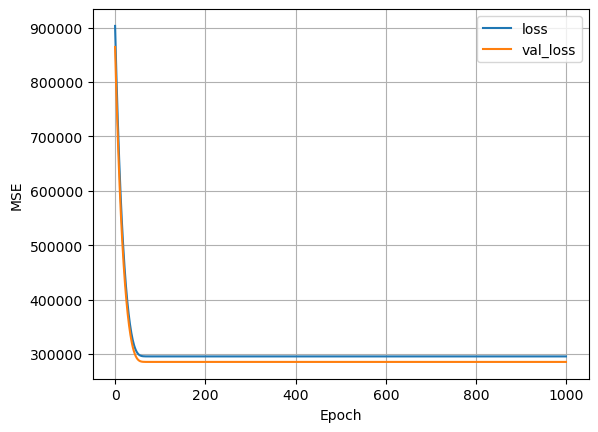

In [23]:
# Plot the loss over epochs using the `plot_loss` function (not shown here).
# This will give a visual representation of how the training and validation loss evolve over time.
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


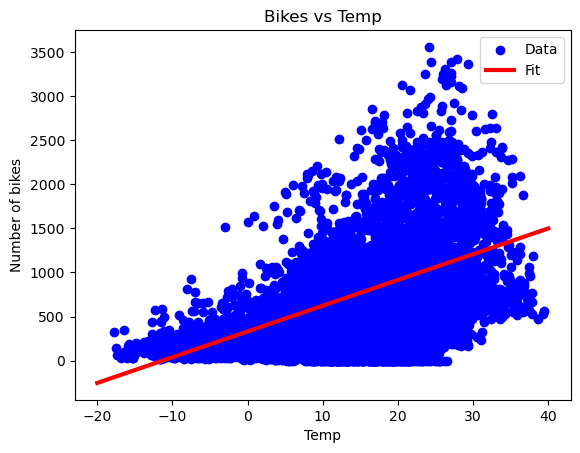

In [24]:
# Scatter plot of training data (temperature vs. bike count).
# It also overlays the regression line (model predictions) on the plot using the `scatter_plot` function.
# 'x_train_temp' is the input temperature data, 'y_train_temp' is the actual bike count data, and 'temp_rnn_model' is the trained model.
scatter_plot(x_train_temp, y_train_temp, temp_rnn_model)

# Neural Net

## With Single Node

In [25]:
# Import necessary modules from TensorFlow and Keras (assumed to be already imported)
# from tensorflow import keras

# Create a normalization layer for the input data (temperature)
# The input_shape parameter specifies that each input sample has one feature
temp_normalizer = keras.layers.Normalization(input_shape=(1,), axis=None)

# Adapt the normalization layer to the training data
# This calculates the mean and variance to normalize the input data
temp_normalizer.adapt(x_train_temp)

In [26]:
# Define a Sequential neural network model
temp_nn_model = keras.Sequential([
    temp_normalizer,                         # First layer: normalizes the input data
    keras.layers.Dense(32, activation="relu"),  # First hidden layer with 32 neurons and ReLU activation
    keras.layers.Dense(32, activation="relu"),  # Second hidden layer with 32 neurons and ReLU activation
    keras.layers.Dense(32, activation="relu"),  # Third hidden layer with 32 neurons and ReLU activation
    keras.layers.Dense(1),                      # Output layer with 1 neuron for regression output
])

# Compile the model
# - Optimizer: Adam with a learning rate of 0.001
# - Loss function: Mean Squared Error for regression
temp_nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error"
)

In [27]:
# Train the model using the training data
history = temp_nn_model.fit(
    x_train_temp,                  # Training features (temperature)
    y_train_temp,                  # Training target (bike count)
    validation_data=(x_valid_temp, y_valid_temp),  # Validation data for monitoring overfitting
    verbose=0,                     # Suppress detailed logging
    epochs=100                     # Number of training epochs
)

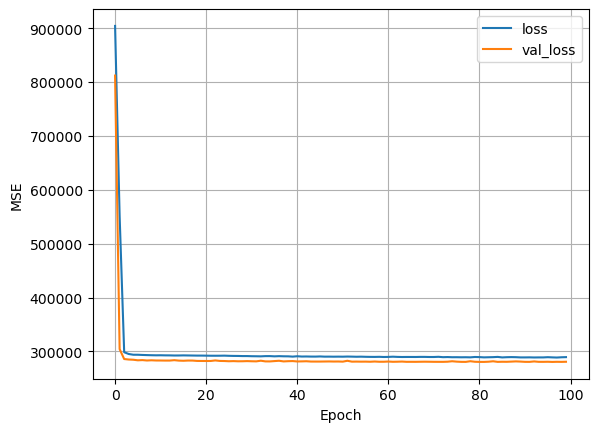

In [28]:
# Plot the training and validation loss over epochs
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


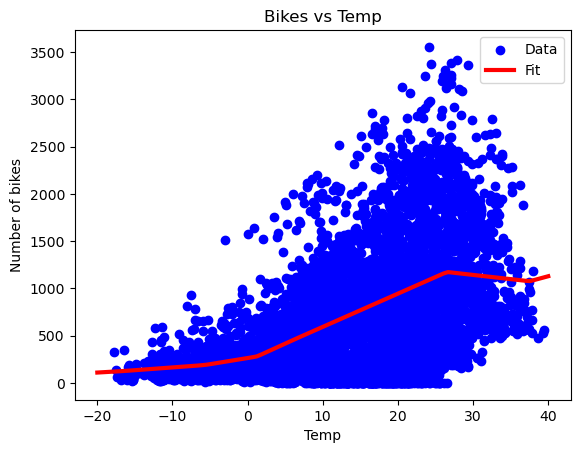

In [29]:
# Scatter plot of training data (temperature vs. bike count) with model predictions
scatter_plot(x_train_temp, y_train_temp, temp_nn_model)

## With Multiple Node

In [30]:
# Import necessary modules from TensorFlow and Keras (assumed to be already imported)
# from tensorflow import keras

# Create a normalization layer for the input data (all 6 features)
# The input_shape parameter specifies that each input sample has 6 features
all_normalizer = keras.layers.Normalization(input_shape=(6,), axis=-1)

# Adapt the normalization layer to the training data (this calculates the mean and variance for normalization)
all_normalizer.adapt(x_train_all)

In [31]:
# Define a Sequential neural network model
all_nn_model = keras.Sequential([
    all_normalizer,                          # First layer: normalizes the input data
    keras.layers.Dense(32, activation="relu"),  # First hidden layer with 32 neurons and ReLU activation
    keras.layers.Dense(32, activation="relu"),  # Second hidden layer with 32 neurons and ReLU activation
    keras.layers.Dense(1),                      # Output layer with 1 neuron for regression output (predicting bike_count)
])

# Compile the model
# - Optimizer: Adam with a learning rate of 0.001
# - Loss function: Mean Squared Error for regression
all_nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error"
)

In [32]:
# Train the model using the training data
history = all_nn_model.fit(
    x_train_all,                 # Training input features (all 6 columns except bike_count)
    y_train_all,                 # Training target values (bike count)
    validation_data=(x_valid_all, y_valid_all),  # Validation data for monitoring overfitting
    verbose=0,                   # Suppress detailed logging
    epochs=100                   # Number of training epochs
)

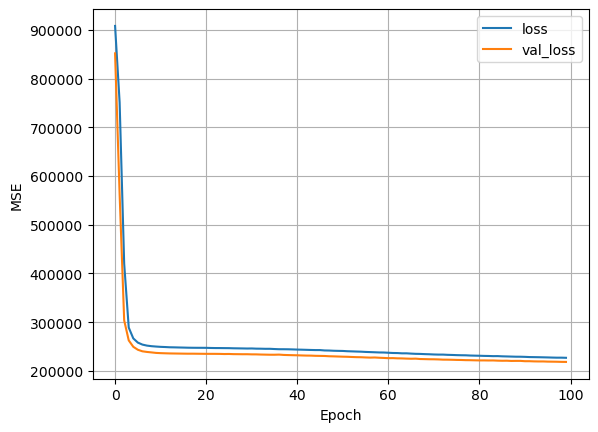

In [33]:
# Plot the training and validation loss over epochs
plot_loss(history)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f089297a7a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


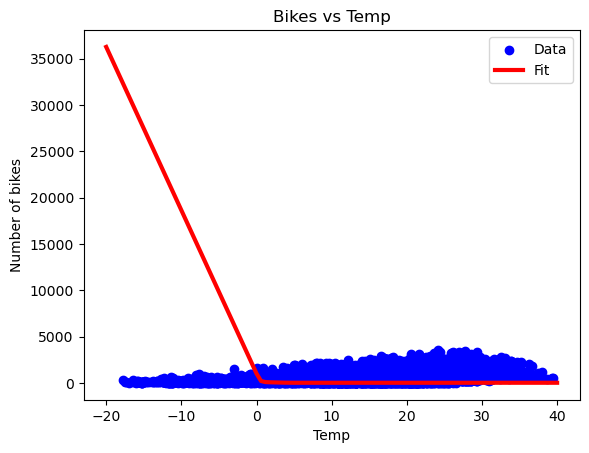

In [34]:
# Scatter plot of training data (using temperature for plotting) vs. bike count, and predicted values from the model
scatter_plot(x_train_temp, y_train_temp, all_nn_model)

## Calculate the Mean Squared Error (MSE) for both Linear Regression and Neural Net

In [35]:
# Predicting the bike count using the Linear Regression model on the test data
y_pred_lr = all_reg.predict(x_test_all)

# Predicting the bike count using the Neural Network model on the same test data
y_pred_nn = all_nn_model.predict(x_test_all)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step


In [36]:
def MSE(y_pred, y_real):
    """
    Calculates the Mean Squared Error (MSE) between predicted and actual values.
    
    Parameters:
    - y_pred: Predicted values (either from Linear Regression or Neural Network).
    - y_real: Actual target values (true bike counts in the test set).
    
    Returns:
    - mse: The mean of the squared differences between predicted and real values.
    """
    return np.square(y_pred - y_real).mean()

In [37]:
# Calculating the MSE for the Linear Regression model
mse_lr = MSE(y_pred_lr, y_test_all)
print("Linear Regression MSE:", mse_lr)

Linear Regression MSE: 256962.4842300011


In [38]:
# Calculating the MSE for the Neural Network model
mse_nn = MSE(y_pred_nn, y_test_all)
print("Neural Network MSE:", mse_nn)

Neural Network MSE: 233758.78922993367


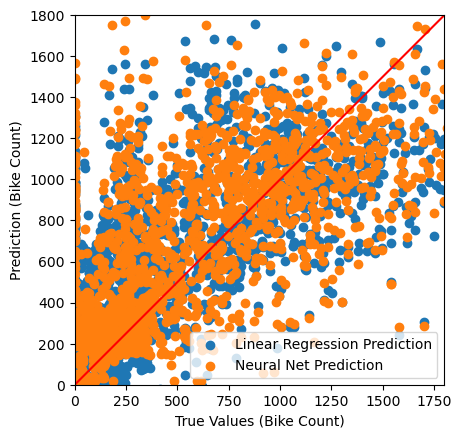

In [39]:
# Visualizing the prediction performance for both models
ax = plt.axes(aspect="equal")  # Create a plot with equal aspect ratio

# Scatter plot for the Linear Regression predictions vs. the true values
plt.scatter(y_test_all, y_pred_lr, label="Linear Regression Prediction")

# Scatter plot for the Neural Network predictions vs. the true values
plt.scatter(y_test_all, y_pred_nn, label="Neural Net Prediction")

# Labeling the plot
plt.xlabel("True Values (Bike Count)")  # x-axis label
plt.ylabel("Prediction (Bike Count)")   # y-axis label

# Setting limits for x and y axes to improve comparison
lim = [0, 1800]  # Assuming bike counts don't exceed 1800
plt.xlim(lim)    # x-axis range from 0 to 1800
plt.ylim(lim)    # y-axis range from 0 to 1800

plt.legend()  # Add a legend to distinguish between the two models

# Plot a red line (y=x), which represents perfect predictions (ideal case)
_ = plt.plot(lim, lim, c="red")

# Display the plot
plt.show()